In [1]:
# import basic functionality and setup notebook params
from preamble import *

# project specific imports
import simpy
import heapq
from scipy.stats import expon, halfnorm
from IPython.display import clear_output

### Simulation Classes and Parameters

In [2]:
'''Simulation Parameters '''

NUM_STATIONS = 2 # number of processing stations
AVG_PROCESSING_RATE = 1/20 # trucks/minutes
AVG_ARRIVAL_RATE = 2/21 # trucks/minute
SIM_LENGTH = 60*24 # minutes

In [3]:
class TruckTerminal:
        
    def __init__(self, env, num_stations = NUM_STATIONS,
                 avg_processing_rate = AVG_PROCESSING_RATE):
        self.env = env
        self.stations = simpy.Resource(env, num_stations)
        self.avg_processing_rate = avg_processing_rate
        self.trucks_processed = 0
        
    def process_truck(self, truck):
        process_time = int(expon.rvs(scale=1/AVG_PROCESSING_RATE) + 0.5) #minutes
        yield self.env.timeout(process_time)
        print(f'{truck} finished processing at {self.env.now:0.2f}')

    def truck_arrival(self, truck_name):
        print(f'Arrival: Truck, {truck_name}, arrives in queue at {self.env.now:0.2f}')
        
        with self.stations.request() as request:
            yield request
            print(f'Begin: Truck, {truck_name}, enters processing station at {self.env.now:0.2f}')
            yield self.env.process(self.process_truck(truck_name))
            print(f'Exit: Truck, {truck_name}, exited station at {self.env.now:0.2f}')
            self.trucks_processed += 1

### Simulation Functions

In [4]:
def simulation(truck_terminal , avg_arrival_rate = AVG_ARRIVAL_RATE,
               init_queue_length = 5):
    
    # fill queue at start with some trucks
    for name in range(1,init_queue_length + 1):
        truck_terminal.env.process(truck_terminal.truck_arrival(name))
        
    while True:
        arrival_time = int(expon.rvs(scale=1/avg_arrival_rate) + 0.5) #minutes
        yield truck_terminal.env.timeout(arrival_time)
        name += 1
        truck_terminal.env.process(truck_terminal.truck_arrival(name))

def run_simulation():
    env = simpy.Environment()
    tt = TruckTerminal(env)
    env.process(simulation(tt))
    env.run(until = SIM_LENGTH)
    return tt.trucks_processed

def truck_processing_distribution(n_sim = 1000):
    trucks_processed = []
    for j in range(n_sim):
        clear_output(wait=True)
        print(f'==== Processing Simulation {j+1} ====')
        trucks_processed.append(run_simulation())
    clear_output(wait=True)
    print(f'===== Truck Processing over {SIM_LENGTH} minutes =====')
    print(f'Mean: {np.mean(trucks_processed)}')
    print(f'Median: {np.median(trucks_processed)}')
    print(f'Standard Deviation: {np.std(trucks_processed)}')
    sns.histplot(trucks_processed)
    plt.xlabel('Number of Trucks Processed Per Simulation')
    plt.title(f'{n_sim} Simulations of Truck Terminal with\n{NUM_STATIONS} Processing Stations for {SIM_LENGTH} minutes')

===== Truck Processing over 1440 minutes =====
Mean: 131.195
Median: 131.0
Standard Deviation: 9.880636366145653


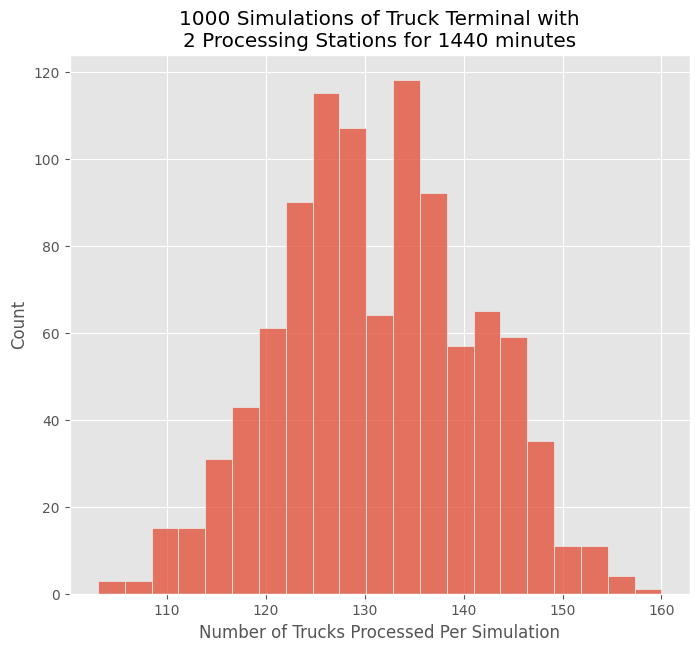

In [5]:
truck_processing_distribution()

### Truck and Priority Queue Classes with Helper Functions
Not used in simulation

In [6]:
class Truck:
    def __init__(self, name, priority):
        self._name = name
        self._priority = priority
    def get_name(self):
        return self._name
    def get_priority(self):
        return self._priority

class PriorityQueue:
    def __init__(self):
        self._data = []
        self._index = 0
        
    def push(self, item, priority):
        heapq.heappush(self._data, (-priority, self._index, item))
        self._index += 1
        
    def pop(self):
        return heapq.heappop(self._data)[-1]
    
    def print_queue(self):
        for x in self._data:
            print(x)
    
def get_random_priority(mean = 0, std=1/3):
    return int(100*halfnorm.rvs(loc = mean, scale=std, size=1))

def add_random_priority_truck(name, que):
    truck = Truck(name, get_random_priority())
    que.push(truck, truck.get_priority())